In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from DataUtils import ImageDataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from scipy.signal import savgol_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
training_data = ImageDataset(
    root_dir="/home/lyk/Projects/dreamerv3/dreamerv3/images",
    train=True,
    transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]),
    preload=True,
)

validation_data = ImageDataset(
    root_dir="/home/lyk/Projects/dreamerv3/dreamerv3/images",
    train=False,
    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]),
    preload=True,
)

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)


In [3]:
data_variance = np.var(training_data.data / 255.0)

In [4]:
(images, _) = next(iter(training_loader))
images = images.to(device) # The original image in the validation set.

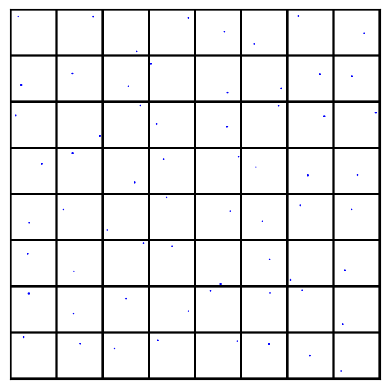

In [5]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

show(make_grid(images.cpu()+0.5))

# Train

In [6]:
batch_size = 256
num_training_updates = 15000 #15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [7]:
from VQ_VAE import Model
import torch.optim as optim

model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
          num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [9]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

checkpoint_path = "checkpoints/VQ-VAE-BouncingBall.pth"


for i in range(num_training_updates):
    # Training step.
    (data, _) = next(iter(training_loader)) # Input data shape: BCHW (256, 3, 32, 32)
    data = data.to(device)
    optimizer.zero_grad()

    codebook_loss, commitment_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    
    # recon_error = F.mse_loss(data_recon, data) / data_variance
    
    # print(f"Origianal recon error: {F.mse_loss(data_recon, data)}")
    # print(f"Variance: {data_variance}")
    # print(f"Scaled Recon error: {recon_error}")
    
    loss = recon_error + codebook_loss + commitment_loss 
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        # Print status.
        print('%d iterations' % (i+1)) # 1-indexed
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()
        
        # Save checkpoint.
        checkpoint = {
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_res_recon_error': train_res_recon_error,
            'train_res_perplexity': train_res_perplexity,
            'loss': loss.item(),
            # Add any other information you need
        }
        
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at iteration {i+1}, target path: {checkpoint_path}")

100 iterations
recon_error: 0.018
perplexity: 1.000

Checkpoint saved at iteration 100, target path: checkpoints/VQ-VAE-BouncingBall.pth
200 iterations
recon_error: 0.001
perplexity: 1.000

Checkpoint saved at iteration 200, target path: checkpoints/VQ-VAE-BouncingBall.pth
300 iterations
recon_error: 0.001
perplexity: 1.000

Checkpoint saved at iteration 300, target path: checkpoints/VQ-VAE-BouncingBall.pth
400 iterations
recon_error: 0.001
perplexity: 1.000

Checkpoint saved at iteration 400, target path: checkpoints/VQ-VAE-BouncingBall.pth
500 iterations
recon_error: 0.001
perplexity: 1.000

Checkpoint saved at iteration 500, target path: checkpoints/VQ-VAE-BouncingBall.pth
600 iterations
recon_error: 0.001
perplexity: 1.000

Checkpoint saved at iteration 600, target path: checkpoints/VQ-VAE-BouncingBall.pth
700 iterations
recon_error: 0.001
perplexity: 1.001

Checkpoint saved at iteration 700, target path: checkpoints/VQ-VAE-BouncingBall.pth
800 iterations
recon_error: 0.001
perplex

# Plot Loss

In [10]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

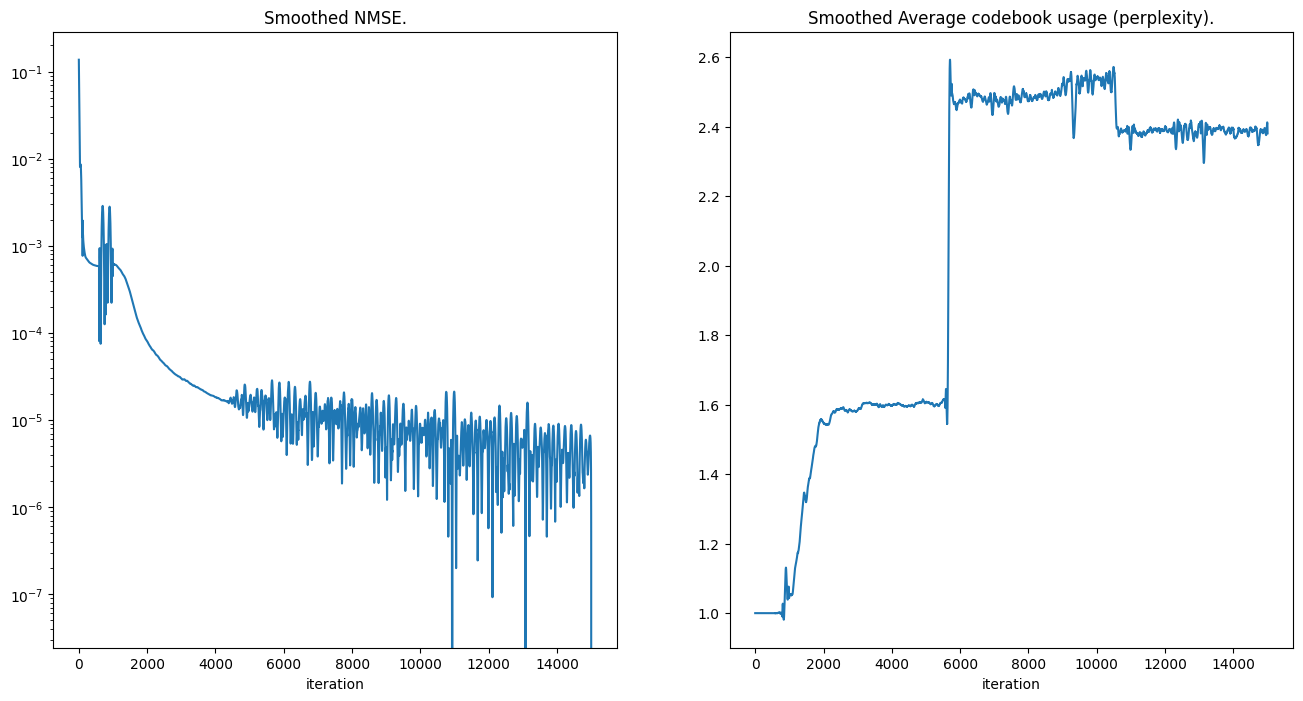

In [11]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

# View recon

In [12]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
checkpoint_path = "checkpoints/VQ-VAE-BouncingBall.pth"  # Update this path
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # Use 'cpu' or 'cuda' as needed
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): Module

In [13]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device) # The original image in the validation set.

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


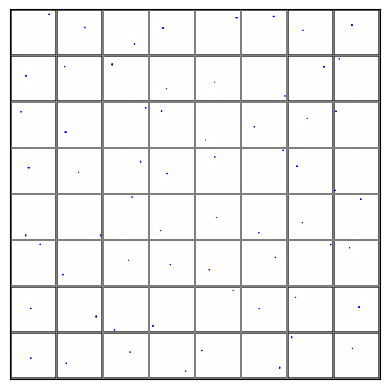

In [14]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

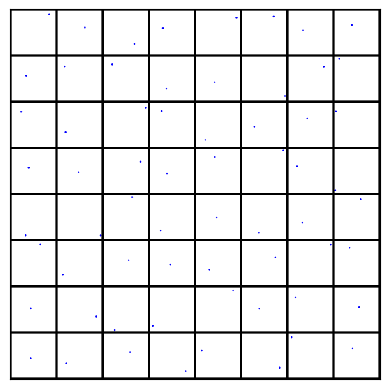

In [15]:
show(make_grid(valid_originals.cpu()+0.5))